In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset_dir = "datasets"

train_file = 'news_traindata'
train_nrows = 110000 * 0.9
train_df = pd.read_csv(f'{dataset_dir}/{train_file}.csv', encoding='utf-8', nrows=train_nrows)
train_df = train_df.dropna()

test_file = 'news_testdata'
test_nrows = 110000 * 0.1
test_df = pd.read_csv(f'{dataset_dir}/{test_file}.csv', encoding='utf-8', nrows=test_nrows)
test_df = test_df.dropna()

vocab_file = f'vocabs/vokab_{train_file}_{train_nrows}.pkl'
model_file = f"models/secondary_model_{train_file}_{train_nrows}.pth"
encoded_testfile = f"encoded/secondary_{test_file}_{test_nrows}.pt"
encoded_trainfile = f"encoded/secondary_{train_file}_{train_nrows}.pt"

In [3]:
train_df['content'] = train_df['title'].fillna('') + ' ' + train_df['content'].fillna('')
test_df['content'] = test_df['title'].fillna('') + ' ' + test_df['content'].fillna('')

In [4]:
import os
import pickle
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from collections import Counter

MAX_VOCAB = 50000
special_tokens = ['<unk>', '<pad>']
tokenizer = get_tokenizer('basic_english')

def generate_vocabulary(df):
    counter = Counter()
    for text in df['content']:
        if pd.notna(text):
            counter.update(tokenizer(str(text)))
    
    most_common = [token for token, _ in counter.most_common(MAX_VOCAB - len(special_tokens))]
    
    vocab = build_vocab_from_iterator([most_common], specials=special_tokens)
    vocab.set_default_index(vocab['<unk>'])

    with open(vocab_file, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"Vocabulary saved to '{vocab_file}'.")

    return vocab


if os.path.exists(vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print(f"Vocabulary loaded from {vocab_file}.")

else:
    vocab = generate_vocabulary(train_df)

Vocabulary loaded from vocabs/vokab_news_traindata_99000.0.pkl.


In [5]:
train_df = train_df[train_df['label'] == 1]
test_df = test_df[test_df['label'] == 1]

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

MAX_LENGTH = 4096

le = LabelEncoder()
train_df['type_encoded'] = le.fit_transform(train_df['type'])
test_df['type_encoded'] = le.transform(test_df['type'])
NUM_CLASSES = len(le.classes_)

def encode_text_secondary_model(vocab, df, encoded_file, le):
    if os.path.exists(encoded_file):
        data = torch.load(encoded_file)
        encoded_texts = data['inputs']
        labels = data['labels']
        return encoded_texts, labels
    
    encoded_texts = []
    labels = []

    for text, label in zip(df['content'], df['type_encoded']):
        if pd.notna(text):
            encoded = [vocab[token] for token in tokenizer(text)]
            
            if len(encoded) <= MAX_LENGTH:  # Filter long sequences
                encoded_texts.append(torch.tensor(encoded, dtype=torch.long))
                labels.append(label)

    encoded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.long)
    labels = F.one_hot(labels, num_classes=NUM_CLASSES).float()
    torch.save({'inputs': encoded_texts, 'labels': labels}, encoded_file)


    return encoded_texts, labels

train_encoded_texts, train_labels = encode_text_secondary_model(vocab, train_df, encoded_trainfile, le)
test_encoded_texts, test_labels = encode_text_secondary_model(vocab, test_df, encoded_testfile, le)

In [8]:
print(train_labels[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


In [17]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = NewsDataset(train_encoded_texts, train_labels)
val_ds = NewsDataset(test_encoded_texts[:500], test_labels[:500])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0)

In [18]:
from mulstage_model import CNN_BiLSTM
from torch import nn


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')

print(f"Using device: {device}")

model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=NUM_CLASSES, pad_idx=vocab['<pad>'])
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)   

Using device: mps


In [19]:
from tqdm import tqdm

def train(model, loader):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(loader, desc="Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_class = preds.argmax(dim=1)
            labels_class = yb.argmax(dim=1)
            total_acc += (preds_class == labels_class).float().mean().item()
    
    return total_acc / len(loader)

print("training")

for epoch in range(1):
    loss = train(model, train_dl)
    acc = evaluate(model, val_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")

training


Epoch 1, Loss: 1.7707, Val Acc: 0.7668


In [23]:
# ===== ADD THESE IMPORTS =====
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [ ]:

# # add these so that the SVC model from the file imports
# from sklearn.svm import SVC
# from sklearn.preprocessing import LabelEncoder
# # 

# from mulstage_model import CNN_BiLSTM, FakeNewsClassifier
# from mulstage_model import SVM_Classifier
# import torch.nn as nn

# svm_classifier = False

# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# print(f"Using device: {device}")
# sec_model = FakeNewsClassifier(input_dim= 100 * 3 + 128 * 2, num_classes=NUM_CLASSES)
# #sec_model = SVM_Classifier(kernel='rbf', C=1.0)
# sec_model.to(device)

# pri_model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=1, pad_idx=vocab['<pad>'])
# pri_model.to(device)

# #pri_model.load_state_dict(torch.load(f"model_news_data_bin_{nrows}.pth", map_location=torch.device('cpu')))
# model_path = os.path.abspath(pri_model_file)
# pri_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# print("done constructing model")


# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(sec_model.parameters(), lr=1e-3)   

# print("done constructing optimizer")
# import torch
# from tqdm import tqdm

# # Modify the extract_features function to collect all features
# def precompute_features(model, dataloader):
#     """
#     Precompute features from the primary model for all samples in the dataloader
#     Returns:
#         all_features: tensor of shape [num_samples, feature_dim]
#         all_labels: tensor of shape [num_samples]
#     """
#     model.eval()  # Set model to evaluation mode
#     all_features = []
#     all_labels = []
    
#     with torch.no_grad():
#         for xb, yb in tqdm(dataloader, desc="Precomputing features"):
#             xb, yb = xb.to(device), yb.to(device)
#             features = model.extract_features(xb)
#             all_features.append(features)
#             all_labels.append(yb)
    
#     # Concatenate all features and labels
#     all_features = torch.cat(all_features, dim=0)
#     all_labels = torch.cat(all_labels, dim=0)
    
#     return all_features, all_labels

# # Create a dataset class for precomputed features
# class PrecomputedFeatureDataset(torch.utils.data.Dataset):
#     def __init__(self, features, labels):
#         self.features = features
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# # Precompute features for training and validation sets
# print("Precomputing features for training set...")
# train_features, train_labels = precompute_features(pri_model, train_dl)
# print(f"Training features shape: {train_features.shape}")

# print("Precomputing features for validation set...")
# val_features, val_labels = precompute_features(pri_model, val_dl)
# print(f"Validation features shape: {val_features.shape}")

# # Create datasets and dataloaders for precomputed features
# train_feature_dataset = PrecomputedFeatureDataset(train_features, train_labels)
# val_feature_dataset = PrecomputedFeatureDataset(val_features, val_labels)

# # Define batch size for the new dataloader (can be different than original)
# batch_size = 64  # Adjust according to your needs

# train_feature_dl = torch.utils.data.DataLoader(
#     train_feature_dataset, 
#     batch_size=batch_size,
#     shuffle=True
# )

# val_feature_dl = torch.utils.data.DataLoader(
#     val_feature_dataset, 
#     batch_size=batch_size,
#     shuffle=False
# )

# # Now modify the training function to use precomputed features
# def train_with_precomputed(sec_model, loader):
#     sec_model.train()
#     total_loss = 0
    
#     for features, labels in tqdm(loader, desc="Training", leave=False):
#         features, labels = features.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         preds = sec_model(features)
#         loss = criterion(preds, labels)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     return total_loss / len(loader)


# # def evaluate_with_precomputed(sec_model, loader):
# #     sec_model.eval()
# #     total_acc = 0
    
# #     with torch.no_grad():
# #         for features, labels in loader:
# #             features, labels = features.to(device), labels.to(device)
            
# #             preds = sec_model(features)
# #             preds_class = preds.argmax(dim=1)
# #             labels_class = labels.argmax(dim=1)
            
# #             total_acc += (preds_class == labels_class).float().mean().item()
    
# #     return total_acc / len(loader)

# def evaluate_with_confusion_matrix(sec_model, loader):
#     sec_model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for features, labels in loader:
#             features, labels = features.to(device), labels.to(device)
#             preds = sec_model(features)
#             preds_class = preds.argmax(dim=1)
#             labels_class = labels.argmax(dim=1)
#             all_preds.extend(preds_class.cpu().numpy())
#             all_labels.extend(labels_class.cpu().numpy())
    
#     return all_labels, all_preds

# def calculate_accuracy(sec_model, loader):
#     all_labels, all_preds = evaluate_with_confusion_matrix(sec_model, loader)
#     return (np.array(all_labels) == np.array(all_preds)).mean()

# # -----------------   For SVM Classifier -----------------

# # def train_with_precomputed(sec_model, loader):
# #     sec_model.train()  # Set the model to training mode
# #     all_features = []
# #     all_labels = []

# #     for features, labels in tqdm(loader, desc="Training", leave=False):
# #         # Ensure on CPU
# #         features = features.cpu()
# #         labels = labels.argmax(dim=1).cpu()  # For multi-class SVM

# #         all_features.append(features)
# #         all_labels.append(labels)

# #     all_features = torch.cat(all_features, dim=0).numpy()
# #     all_labels = torch.cat(all_labels, dim=0).numpy()

# #     sec_model.fit(all_features, all_labels)


# # def evaluate_with_confusion_matrix(sec_model, loader):
# #     all_preds = []
# #     all_labels = []

# #     for features, labels in loader:
# #         features = features.cpu().numpy()
# #         labels = labels.argmax(dim=1).cpu().numpy()

# #         preds = sec_model.predict(features)

# #         all_preds.extend(preds)
# #         all_labels.extend(labels)

# #     return all_labels, all_preds

# # def calculate_accuracy(sec_model, loader):
# #     all_labels, all_preds = evaluate_with_confusion_matrix(sec_model, loader)
# #     return (np.array(all_labels) == np.array(all_preds)).mean()



Using device: mps
done constructing model
done constructing optimizer
Precomputing features for training set...


Precomputing features: 100%|██████████| 2441/2441 [03:37<00:00, 11.23it/s]


Training features shape: torch.Size([78081, 556])
Precomputing features for validation set...


Precomputing features: 100%|██████████| 272/272 [00:26<00:00, 10.37it/s]

Validation features shape: torch.Size([8676, 556])


In [29]:
from mulstage_model import CNN_BiLSTM, FakeNewsClassifier
import torch.nn as nn

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
sec_model = FakeNewsClassifier(input_dim= 100 * 3 + 128 * 2, num_classes=NUM_CLASSES)
sec_model.to(device)

pri_model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=1, pad_idx=vocab['<pad>'])
pri_model.to(device)

#pri_model.load_state_dict(torch.load(f"model_news_data_bin_{nrows}.pth", map_location=torch.device('cpu')))
model_path = os.path.abspath(pri_model_file)
pri_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

print("done constructing model")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sec_model.parameters(), lr=1e-3)   

print("done constructing optimizer")
import torch
from tqdm import tqdm

# Modify the extract_features function to collect all features
def precompute_features(model, dataloader):
    """
    Precompute features from the primary model for all samples in the dataloader
    Returns:
        all_features: tensor of shape [num_samples, feature_dim]
        all_labels: tensor of shape [num_samples]
    """
    model.eval()  # Set model to evaluation mode
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Precomputing features"):
            xb, yb = xb.to(device), yb.to(device)
            features = model.extract_features(xb)
            all_features.append(features)
            all_labels.append(yb)
    
    # Concatenate all features and labels
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels

# Create a dataset class for precomputed features
class PrecomputedFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Precompute features for training and validation sets
print("Precomputing features for training set...")
train_features, train_labels = precompute_features(pri_model, train_dl)
print(f"Training features shape: {train_features.shape}")

print("Precomputing features for validation set...")
val_features, val_labels = precompute_features(pri_model, val_dl)
print(f"Validation features shape: {val_features.shape}")

# Create datasets and dataloaders for precomputed features
train_feature_dataset = PrecomputedFeatureDataset(train_features, train_labels)
val_feature_dataset = PrecomputedFeatureDataset(val_features, val_labels)

# Define batch size for the new dataloader (can be different than original)
batch_size = 64  # Adjust according to your needs

train_feature_dl = torch.utils.data.DataLoader(
    train_feature_dataset, 
    batch_size=batch_size,
    shuffle=True
)

val_feature_dl = torch.utils.data.DataLoader(
    val_feature_dataset, 
    batch_size=batch_size,
    shuffle=False
)

# Now modify the training function to use precomputed features
def train_with_precomputed(sec_model, loader):
    sec_model.train()
    total_loss = 0
    
    for features, labels in tqdm(loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        preds = sec_model(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

# def evaluate_with_precomputed(sec_model, loader):
#     sec_model.eval()
#     total_acc = 0
    
#     with torch.no_grad():
#         for features, labels in loader:
#             features, labels = features.to(device), labels.to(device)
            
#             preds = sec_model(features)
#             preds_class = preds.argmax(dim=1)
#             labels_class = labels.argmax(dim=1)
            
#             total_acc += (preds_class == labels_class).float().mean().item()
    
#     return total_acc / len(loader)

def evaluate_with_confusion_matrix(sec_model, loader):
    sec_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            preds = sec_model(features)
            preds_class = preds.argmax(dim=1)
            labels_class = labels.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels_class.cpu().numpy())
    
    return all_labels, all_preds

def calculate_accuracy(sec_model, loader):
    all_labels, all_preds = evaluate_with_confusion_matrix(sec_model, loader)
    return (np.array(all_labels) == np.array(all_preds)).mean()


Using device: mps
done constructing model
done constructing optimizer
Precomputing features for training set...


Precomputing features: 100%|██████████| 2441/2441 [03:34<00:00, 11.40it/s]


Training features shape: torch.Size([78081, 556])
Precomputing features for validation set...


Precomputing features: 100%|██████████| 272/272 [00:28<00:00,  9.46it/s]

Validation features shape: torch.Size([8676, 556])


In [34]:

# Training loop using precomputed features
print("Training with precomputed features")
for epoch in range(200):
    loss = train_with_precomputed(sec_model, train_feature_dl)
    acc = calculate_accuracy(sec_model, val_feature_dl)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")

# print("Training with precomputed features")
#     # Train the SVM model with precomputed features
# train_with_precomputed(sec_model, train_feature_dl)  # Fit the SVM to the features
# acc = calculate_accuracy(sec_model, val_feature_dl)
# print(f"Epoch {1}, Val Acc: {acc:.4f}")

Training with precomputed features


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x256 and 512x128)

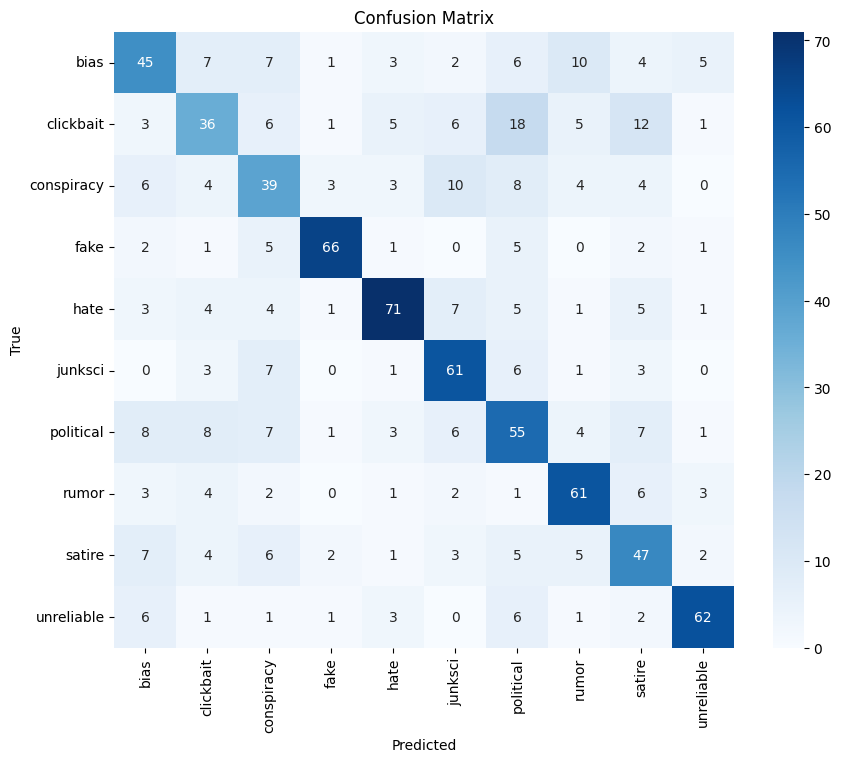

              precision    recall  f1-score   support

        bias       0.54      0.50      0.52        90
   clickbait       0.50      0.39      0.44        93
  conspiracy       0.46      0.48      0.47        81
        fake       0.87      0.80      0.83        83
        hate       0.77      0.70      0.73       102
     junksci       0.63      0.74      0.68        82
   political       0.48      0.55      0.51       100
       rumor       0.66      0.73      0.70        83
      satire       0.51      0.57      0.54        82
  unreliable       0.82      0.75      0.78        83

    accuracy                           0.62       879
   macro avg       0.62      0.62      0.62       879
weighted avg       0.62      0.62      0.62       879


Top Misclassified Pairs:
clickbait → political: 18 cases
clickbait → satire: 12 cases
conspiracy → junksci: 10 cases
bias → rumor: 10 cases
political → bias: 8 cases


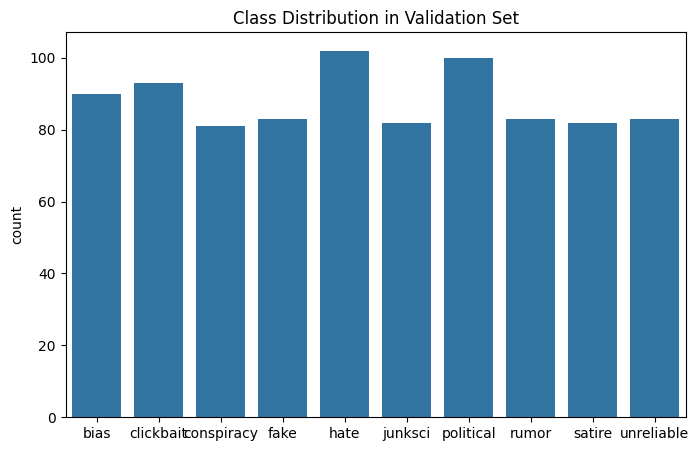

In [ ]:
# ===== ADD THIS SECTION AFTER TRAINING =====
# Get predictions and true labels
true_labels, pred_labels = evaluate_with_confusion_matrix(sec_model, val_feature_dl)

# Confusion Matrix
class_names = le.classes_
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Top Misclassified Pairs
errors = np.where(np.array(true_labels) != np.array(pred_labels))[0]
misclassified_pairs = list(zip(np.array(true_labels)[errors], np.array(pred_labels)[errors]))
top_misclassified = Counter(misclassified_pairs).most_common(5)
print("\nTop Misclassified Pairs:")
for (true, pred), count in top_misclassified:
    print(f"{class_names[true]} → {class_names[pred]}: {count} cases")

# Class Distribution Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=true_labels)
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.title('Class Distribution in Validation Set')
plt.show()